# Battery Lifecycle Aggregation:  

----
## Background: 

In this video, we're going to review how you can compare battery lifecycle performance across multiple conditions. We're going to use the same dataset that we covered in the coulomb counting lecture. If you're not familiar with coulomb counting, you may want to check out that video first. 

Now a quick recap. The dataset we're using is from an accelerated aging test conducted by NASA. They tested 33 different battery cells, and each of them went through a series of cycling and impedance tests. Once the cells lost 30% of their usable capacity, the test ended. For more background on the tests or the results, check out their description here: https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/<sup>1</sup>

The dataset can be pulled from the same link, or from kaggle: https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset.<sup>2</sup>

That should be enough of a background, so let's dive into the dataset. We're going to start with some simple code to calculate the capacity for a single cell for one data file. Then we will extend it across life, and finally we're going to loop it through for each unique cell in the test dataset.   

----
## Code: 

In [1]:
#Let's begin by importing our necessary packages: 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import csv

# next we're going to load our data and make a list of all the files listed in the files column. 
df_meta = pd.read_csv('C:\\Users\\ldsjo\\Youtube Training Videos\\Coulomb Counting\\metadata.csv')

#Let's check the meta data information
df_meta.head(5)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [2]:
# So in the metadata we see different test types specified, the dates they started, the temperature of the test, and
# other useful metrics like capacity, and test id -- but capacity appears empty for some tests. Let's fix that.  

# To snag capacity capacity for each cell across all test files let's confirm the headers are the same. 
# This might seem obvious, but if  they're using different test equipment or channel setups, it's possible
# They do not match. We'll do this by loading our metadata file, extracting file names from it, then use those
# names to extract the header. 

# Get all Files
files = list(df_meta["filename"])

#and strip out the ones we know we don't want (metadata, charge, and discharge)
exclusion = ["metadata.csv", "charge.csv", "discharge.csv"]
files = [file for file in files if file not in exclusion]

# Set the filepath ready for each file.
path = 'C:\\Users\\ldsjo\\Youtube Training Videos\\Coulomb Counting\\data\\'
filepaths = [path + file for file in files]

# We're going to use a simple function to check the file headers
def get_header(filename):
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        header = next(csv_reader)
    return header

# and we'll use list comprehension to get the headers. Now there's quite a bit of files here (>7,000 files)
# so this could take a few minutes. This is good example why in battery data analysis, we often want to find 
# the most efficient ways to analyze data. This is why we're directly using csv reader instead of pandas. 
# Admittedly, there's better ways to manage datasets, but for what we're trying to accomplish here, this will be fine. 

headers = [get_header(filepath) for filepath in filepaths]
headers

[['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_load',
  'Voltage_load',
  'Time'],
 ['Sense_current',
  'Battery_current',
  'Current_ratio',
  'Battery_impedance',
  'Rectified_Impedance'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_charge',
  'Voltage_charge',
  'Time'],
 ['Sense_current',
  'Battery_current',
  'Current_ratio',
  'Battery_impedance',
  'Rectified_Impedance'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_load',
  'Voltage_load',
  'Time'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_charge',
  'Voltage_charge',
  'Time'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_load',
  'Voltage_load',
  'Time'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',
  'Current_charge',
  'Voltage_charge',
  'Time'],
 ['Voltage_measured',
  'Current_measured',
  'Temperature_measured',


In [4]:
# Now one way to check if these are all the same is to load this into pandas as a dataframe and drop our duplicates.
# This will tell us which are the same vs. different. 

df_headers = pd.DataFrame(headers, columns=['Column1', 'Column2', 'Column3', 'Column4', "column5", 'column6'])
df_headers = df_headers.drop_duplicates()
df_headers

# Alright, so there's three distinct data structures being used. It'll be easiest if we convert all of them 
# To the same dataframe structure, and we don't need the impedance testing for what we're trying to do.
# Before we do that though, let's partition the dataframe into smaller ones that contain only one cell at 
# a time

,Column1,Column2,Column3,Column4,column5,column6
0,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
1,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance,None
2,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time


In [5]:
#Get all cell IDs and prepare to concatenate the filenames:
cell_ids = list(set(df_meta["battery_id"]))
file_list = []
for cell_id in cell_ids:
    temp_list = list(df_meta[(df_meta["type"] != "impedance") & (df_meta["battery_id"] == cell_id)]["filename"])
    file_list.append(temp_list)  


# Now what we're going to do is monitor the capacity, total throughput, and temperature for each unique battery cell. 
# To do this we will make a list of dataframes, that has only the dataframe for each list of tests associated with 
# A given cell. 


# Now lets add our capacity measurement function: 
def couloumb_count(df): 
    new_column_names = ['Voltage_measured', 'Current_measured', 'Temperature_measured',
                        'Current_load','Voltage_load', "Time" ]
    df.columns = new_column_names
    voltage = df["Voltage_measured"]
    current = df["Current_measured"]
    time = df["Time"]
    energy_list = []
    throughput = 0 
    for i in range(len(voltage)): 
        if i < len(voltage) - 1: 
            energy = current[i] * (time[i+1] - time[i]) / 3600 
            energy_list.append(energy)
            throughput += energy   
            
    #Pull the mean temperature from the dataframe: 
    avg_temp = np.mean(df["Temperature_measured"])
    avg_current = np.mean(df["Current_measured"])
    
    return(throughput, avg_temp, avg_current)


# And let's bring in our dataframe reading function
def df_reader(filepath):
    df = pd.read_csv(filepath)
    new_column_names = ['Voltage_measured', 'Current_measured', 'Temperature_measured',
                        'Current_load','Voltage_load', "Time" ]
    df.columns = new_column_names
    throughput, avg_temp, avg_current = couloumb_count(df)
    output = [throughput, avg_temp, avg_current]
    return(output)

In [6]:
#Now let's our df_reader. We're going to iterate by collecting results for each battery id

path = 'C:\\Users\\ldsjo\\Youtube Training Videos\\Coulomb Counting\\data\\'

agg_cell_test_data = []
for i in range(len(cell_ids)):
    total_throughput = 0
    cell_test_data =[]
    for j in range(len(file_list[i])):
        df_outputs = df_reader(path +file_list[i][j])
        throughput = df_outputs[0]
        total_throughput += abs(throughput)
        avg_temp = df_outputs[1]
        avg_current = df_outputs[2]
        cell_data = {"throughput": throughput, "avg_temp": avg_temp, "avg_current": avg_current, 
                     "cumulative_throughput": total_throughput}
        cell_test_data.append(cell_data)
        if j == len(file_list[i])-1:
            agg_cell_test_data.append({cell_ids[i]:cell_test_data})
print("Aggregation complete")

Aggregation complete


In [7]:
agg_cell_test_data


[{'B0030': [{'throughput': -1.7031178493297752,
    'avg_temp': 52.450611378612734,
    'avg_current': -3.881093691840246,
    'cumulative_throughput': 1.7031178493297752},
   {'throughput': 1.8504308816096315,
    'avg_temp': 45.42371660764962,
    'avg_current': 0.7162067821453456,
    'cumulative_throughput': 3.553548730939407},
   {'throughput': -1.8181219474140375,
    'avg_temp': 54.113241117794225,
    'avg_current': -3.7838858314888455,
    'cumulative_throughput': 5.3716706783534445},
   {'throughput': 1.8239421764782906,
    'avg_temp': 45.57575640522429,
    'avg_current': 0.7181540581242659,
    'cumulative_throughput': 7.195612854831735},
   {'throughput': -1.7987223412565456,
    'avg_temp': 54.157828260748424,
    'avg_current': -3.78000742647211,
    'cumulative_throughput': 8.994335196088281},
   {'throughput': 1.8083491561557654,
    'avg_temp': 45.63280912752357,
    'avg_current': 0.712579852304918,
    'cumulative_throughput': 10.802684352244047},
   {'throughput':

In [8]:
# Okay great, so now we've ran our coloumb counting script for all cells and aggregated them to a nested dictionary list
# For easy of readability, I'm going to pass this through as a new dataframe, output a copy in a csv format and then we'll 
# get to plotting. Now if your unfamiliar, there's many ways you can output data with the pandas library. Some examples include
# csv, JSON, and excel based formats. 

output_data = [{**{'Cell ID': key}, **value} for entry in agg_cell_test_data for key, 
                  values in entry.items() for value in values]

# Create DataFrame from the flattened data
output_df = pd.DataFrame(output_data)
output_df.head(10)

,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput
0,B0030,-1.703118,52.450611,-3.881094,1.703118
1,B0030,1.850431,45.423717,0.716207,3.553549
2,B0030,-1.818122,54.113241,-3.783886,5.371671
3,B0030,1.823942,45.575756,0.718154,7.195613
4,B0030,-1.798722,54.157828,-3.780007,8.994335
5,B0030,1.808349,45.632809,0.712580,10.802684
6,B0030,-1.788773,54.212019,-3.777196,12.591457
7,B0030,1.797012,45.658192,0.712944,14.388469
8,B0030,-1.775359,54.198377,-3.774391,16.163828
9,B0030,1.784594,44.936663,0.699477,17.948423


In [9]:
# Now before we plot there's a few items we want to add. First, we want to add the capacity retention, second we want a
# Total throughput tracker so we can plot vs. the effective cycle-age of the battery cell. Let's do that now. Since we
# Don't have more detail on the battery cell design, or a lower C-rate OCV, we'll approximate the cell capacity 
# for BOL based on the max throughput input to the cell. 

cell_max_throughputs = output_df.groupby("Cell ID")["throughput"].max().to_dict()
cell_max_throughputs

cap_ret = []
cap_list = []
for i in range(len(output_df)):
    cell = output_df["Cell ID"][i]
    capacity = abs(output_df["throughput"][i]) / cell_max_throughputs[cell]
    cap_list.append(capacity)
output_df["Charge-approximated Capacity"] = cap_list
output_df=output_df.dropna()

# Great, so now we add our capacity retention and our dataframe ready. 
output_df

,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput,Charge-approximated Capacity
0,B0030,-1.703118,52.450611,-3.881094,1.703118,0.920390
1,B0030,1.850431,45.423717,0.716207,3.553549,1.000000
2,B0030,-1.818122,54.113241,-3.783886,5.371671,0.982540
3,B0030,1.823942,45.575756,0.718154,7.195613,0.985685
4,B0030,-1.798722,54.157828,-3.780007,8.994335,0.972056
...,...,...,...,...,...,...
5604,B0007,1.421408,25.431336,0.541790,554.418152,0.739092
5605,B0007,-1.445752,32.818049,-1.856101,555.863904,0.751750
5606,B0007,1.446901,25.138344,0.535054,557.310805,0.752347
5607,B0007,-1.456424,32.929412,-1.857437,558.767229,0.757299


In [10]:
# Now the last step we'll want to do before plotting is tethering the test condition to each cell. 
# Based on the Read.me files from the kaggle link, let's set a csv file we can import and merge to link them together 
output_df.sample(5)

,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput,Charge-approximated Capacity
1650,B0018,-1.852990,31.316913,-1.952051,10.097358,0.990826
5018,B0055,1.321811,6.112883,0.450423,114.020814,0.808168
2967,B0005,1.550352,26.215570,0.551747,319.650589,0.823711
4000,B0056,1.165798,6.120406,0.399842,95.038046,0.755624
1681,B0018,1.769520,25.562018,0.628178,66.430852,0.946193


In [12]:
meta_df = pd.read_csv("meta_tags.csv")
merged_df = pd.merge(output_df, meta_df, on='Cell ID', how='left')
merged_df.sample(5)

,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput,Charge-approximated Capacity,Ambient Temperature (deg C),Charge profile (A),Discharge Profile,Vmax,Vmin,EIS Low (Hz),EIS High (Hz)
887,B0033,1.765339,27.157835,0.611847,55.535162,0.943382,24,1.5,4A,4.2,2.0,0.1,5000
3697,B0046,1.251446,6.705143,0.418782,131.111192,0.799375,4,1.5,1A,4.2,2.2,0.1,5000
3300,B0044,1.536393,24.189999,0.538082,60.674466,0.917777,4,1.5,4A & 1A,4.2,2.7,0.1,5000
3393,B0050,0.714881,6.144285,0.244300,41.529688,0.382373,4,1.5,2A,4.2,2.2,0.1,5000
2645,B0032,1.835877,45.378950,0.736781,29.663446,0.949462,43,1.5,4A,4.2,2.7,0.1,5000


In [13]:
# We'll add a unique column. Since it looks like Vmax, Charge Current, and EIS frequency min/max don't change, we'll 
# just focus on the discharge profile, temp, and min voltage. 
merged_df["Unique_Condition"] = ("Temp: " 
                                 + merged_df["Ambient Temperature (deg C)"].astype(str)
                                 + "Discharge Profile"
                                 + merged_df["Discharge Profile "].astype(str)
                                 + "Min Voltage"
                                 + merged_df["Vmin"].astype(str))

# Next to avoid having to recreate this again, we'll export the dataframe to CSV so we can recall it for future analysis. 
merged_df.to_csv("Aggregated_Test_Data.csv")

In [14]:
merged_df = pd.read_csv("Aggregated_Test_Data.csv")
merged_df.sample(5)

,Unnamed: 0,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput,Charge-approximated Capacity,Ambient Temperature (deg C),Charge profile (A),Discharge Profile,Vmax,Vmin,EIS Low (Hz),EIS High (Hz),Unique_Condition
448,448,B0053,-1.334641,12.163074,-1.993681,31.687278,0.897859,4,1.5,2A,4.2,2.0,0.1,5000,Temp: 4Discharge Profile2AMin Voltage2.0
1935,1935,B0005,-1.728921,32.168099,-1.908341,200.132049,0.918587,20,1.5,2A,4.2,2.7,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.7
3796,3796,B0029,-1.734642,52.862763,-3.891007,88.970930,0.906801,43,1.5,4A,4.2,2.0,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.0
2120,2120,B0005,-1.321248,33.465018,-1.679794,477.140998,0.701987,20,1.5,2A,4.2,2.7,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.7
3222,3222,B0040,1.728188,45.454704,0.689078,70.304877,0.998169,24 & 44,1.5,4A,4.2,2.7,0.1,5000,Temp: 24 & 44Discharge Profile4AMin Voltage2.7


### Now, Let's plot the results

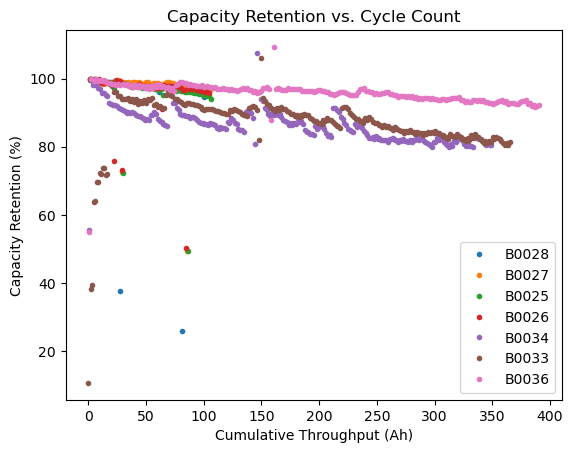

In [15]:
# Just to get a visual understand of what the data looks like we'll through it on a scatter plot using matplotlib. 
# it's going to look a bit messy and this should highlight areas where our data might need additional filtering.  
def cell_plotter(df): 
    cells = list(set(df["Cell ID"]))
    for i in range(len(cells)): 
        temp_df = df[df["Cell ID"]==cells[i]]
        x = temp_df["cumulative_throughput"]
        y = temp_df["Charge-approximated Capacity"]*100
        plt.plot(x,y, '.',label=cells[i])
        #print(y.iloc[0])
        plt.legend()
        plt.title("Capacity Retention vs. Cycle Count")
        plt.xlabel("Cumulative Throughput (Ah)")
        plt.ylabel("Capacity Retention (%)")
        #plt.ylim(80,105)
plot_df = merged_df[merged_df["Ambient Temperature (deg C)"]=="24"]
cell_plotter(plot_df)

**Okay, so a few things we should note here:**<br>

1. First, we see some clear outliers in our supposed capacity retention within the first 100 cycles or so. It's likely
that these tests were simply partial charges, not a full charge from 2.2-2.8V up to 4.2V. As a practice, it's always 
best to confirm with the researcher that performed the experiment in the first place. 
<br><br>
2. Second, we see what seems like a reset in capacity every 50 cycles or so. A linear decline, then a step-wise jump, followed 
by another linear decline. We might be tempted to write this off as more error in test execution or script coloumb counting. 
However, publications have shown some cyclable capacity can be restored by implementing extended rest periods and by applying 
certain load profiles intermittently after repetitive cycling.<sup>3</sup> 

Still, we'd like visually compare how battery degradation compares across different test conditions like temperature,
applied load, and operating voltage window. We're going to make an array of plots using matplotlib. 

In [16]:
# Let's start by filtering some of the concerning measurements. We know we should not expect significant drops in 
# capacity followed by an abrupt rise. This is likely a test that ended early and was separated as a file instead.

# Boolean mask to check where the dataframe has the same test conditions
same_condition_mask = merged_df['Unique_Condition'] == merged_df['Unique_Condition'].shift()

# Calculate the absolute difference in capacity retention between consecutive rows with the same unique condition
retention_diff = abs(merged_df['Charge-approximated Capacity'] - merged_df['Charge-approximated Capacity'].shift())

# Filter rows where the difference exceeds 20% fade for each unique test condition
filtered_rows = merged_df.index[(same_condition_mask) & (retention_diff > 0.05)].tolist()

# set the remaining dataframe
merged_df = merged_df[~merged_df.index.isin(filtered_rows)]
merged_df.reset_index(drop=True)

,Unnamed: 0,Cell ID,throughput,avg_temp,avg_current,cumulative_throughput,Charge-approximated Capacity,Ambient Temperature (deg C),Charge profile (A),Discharge Profile,Vmax,Vmin,EIS Low (Hz),EIS High (Hz),Unique_Condition
0,0,B0030,-1.703118,52.450611,-3.881094,1.703118,0.920390,43,1.5,4A,4.2,2.2,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.2
1,2,B0030,-1.818122,54.113241,-3.783886,5.371671,0.982540,43,1.5,4A,4.2,2.2,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.2
2,3,B0030,1.823942,45.575756,0.718154,7.195613,0.985685,43,1.5,4A,4.2,2.2,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.2
3,4,B0030,-1.798722,54.157828,-3.780007,8.994335,0.972056,43,1.5,4A,4.2,2.2,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.2
4,5,B0030,1.808349,45.632809,0.712580,10.802684,0.977258,43,1.5,4A,4.2,2.2,0.1,5000,Temp: 43Discharge Profile4AMin Voltage2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,4507,B0007,-1.424460,32.576296,-1.835606,552.996744,0.740678,20,1.5,2A,4.2,2.2,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.2
4267,4508,B0007,1.421408,25.431336,0.541790,554.418152,0.739092,20,1.5,2A,4.2,2.2,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.2
4268,4509,B0007,-1.445752,32.818049,-1.856101,555.863904,0.751750,20,1.5,2A,4.2,2.2,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.2
4269,4510,B0007,1.446901,25.138344,0.535054,557.310805,0.752347,20,1.5,2A,4.2,2.2,0.1,5000,Temp: 20Discharge Profile2AMin Voltage2.2


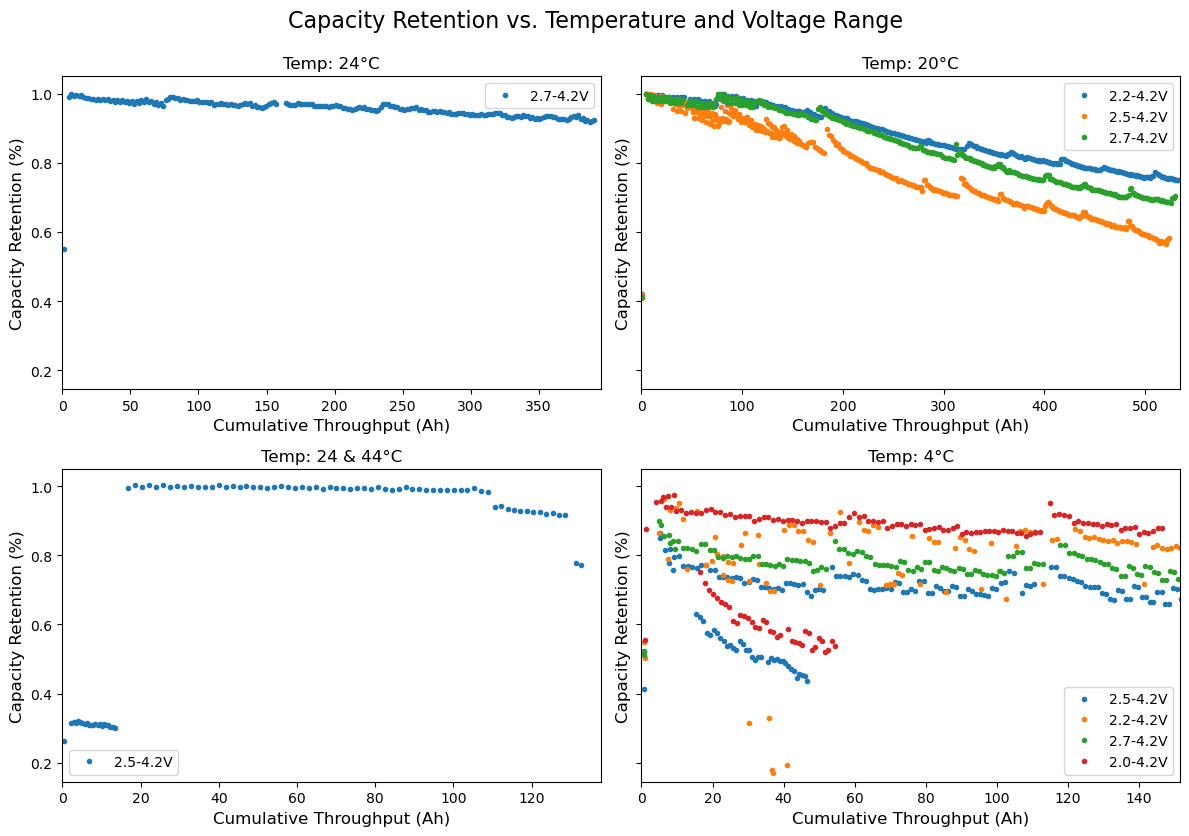

In [17]:
subset_df = merged_df[(merged_df["Discharge Profile "] == "2A")]
unique_conditions = list(set(subset_df["Unique_Condition"]))
temps = list(set(subset_df["Ambient Temperature (deg C)"]))

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

for idx, temp in enumerate(temps):
    row = idx // 2
    col = idx % 2
    temp_df = subset_df[subset_df["Ambient Temperature (deg C)"] == temp]
    temp_conditions = list(set(temp_df["Unique_Condition"]))
    for condition in temp_conditions:
        condition_df = temp_df[temp_df["Unique_Condition"] == condition]
        voltage = condition_df["Vmin"].iloc[0]
        capacity = condition_df["Charge-approximated Capacity"]
        throughput = condition_df["cumulative_throughput"]
        disch = condition_df["Discharge Profile "].iloc[0]
        axs[row, col].plot(throughput, capacity, '.', label="{}-4.2V".format(voltage)) # & temp {}°C

    axs[row, col].legend()

    # Set x and y axis limits
    axs[row, col].set_xlim([0, max(throughput)+5])  # Adjust the limits as needed
    axs[row, col].set_ylim([min(capacity)+0.05,1.05])     # Adjust the limits as needed
    axs[row, col].set_xlabel('Cumulative Throughput (Ah)',fontsize="12")  # Moved from plt.xlabel
    axs[row, col].set_ylabel('Capacity Retention (%)',fontsize="12")  # Moved from plt.ylabel
    axs[row, col].set_title("Temp: {}°C".format(temp),fontsize="12")  # Moved from plt.ylabel
plt.tight_layout()
fig.suptitle('Capacity Retention vs. Temperature and Voltage Range', fontsize=16, y=1.04 )

plt.show()

### Citations: 

1. https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/
2. https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset
3. https://www.sciencedirect.com/science/article/abs/pii/S2352152X18308053
